In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\main.parquet")

### Importing the raw data file

In [3]:
df

,Time,P_kW,Q_kvar,S_kVA,PF,Freq_Hz,Vnavg_V,Vlavg_V,Iavg_A,Va_V,...,system_kWh,gen1_litres_model,gen2_litres_model,gen3_litres_model,Total_Litres,diesel_prices,grid_tariff,daily_price_of_used,starting_Litres,mon
0,2022-09-17 12:38:00,39.946,19.512,44.773,0.892,50.364,231.265,400.564,63.974,232.619,...,0.667800,0,0.0,0.000000,0.000000,700,60.27525,0.000000,20000.000000,9
1,2022-09-17 12:39:00,35.559,20.307,41.256,0.862,50.374,231.389,400.779,58.764,232.742,...,0.594767,0,0.0,0.000000,0.000000,700,60.27525,0.000000,20000.000000,9
2,2022-09-17 12:40:00,36.457,19.760,41.744,0.873,50.384,231.065,400.217,64.488,232.380,...,0.609783,0,0.0,0.000000,0.000000,700,60.27525,0.000000,20000.000000,9
3,2022-09-17 12:48:00,32.077,23.494,40.033,0.801,50.029,239.320,414.516,52.482,239.213,...,0.537150,0,0.0,0.256666,0.256666,700,60.27525,179.666268,19999.743334,9
4,2022-09-17 12:49:00,29.221,22.707,37.292,0.784,50.020,239.245,414.385,52.125,239.100,...,0.489600,0,0.0,0.247874,0.247874,700,60.27525,173.511576,19999.495460,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194020,2023-01-31 23:55:00,58.401,14.435,60.245,0.969,50.285,226.073,391.599,90.862,230.504,...,0.973417,0,0.0,0.000000,0.000000,700,60.27525,0.000000,9375.315533,1
194021,2023-01-31 23:56:00,58.010,14.231,59.828,0.970,50.285,225.837,391.193,88.591,230.275,...,0.966533,0,0.0,0.000000,0.000000,700,60.27525,0.000000,9375.315533,1
194022,2023-01-31 23:57:00,56.409,14.335,58.331,0.967,50.295,225.696,390.948,86.557,230.144,...,0.940200,0,0.0,0.000000,0.000000,700,60.27525,0.000000,9375.315533,1
194023,2023-01-31 23:58:00,58.337,14.059,60.106,0.971,50.295,225.866,391.242,89.269,230.336,...,0.972350,0,0.0,0.000000,0.000000,700,60.27525,0.000000,9375.315533,1


#### Selecting the Time and System Kw column as the required column for this model development

In [4]:
df = df[['Time','system_kW']]

df['Time'] = pd.to_datetime(df['Time'])

# df['new_date'] = [d.date() for d in df['Time']]
# df['new_time'] = [d.time() for d in df['Time']]

# import pandas as pd

# # Get week number, with pd.DateOffset used to start the week on Sunday
# week_date_values = df["Time"].dt.isocalendar()
# df["week_date"] = (df['Time'] - pd.to_timedelta(df['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# # Combine with "(week n)" values
# df["week_date"] = df["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
df

,Time,system_kW
0,2022-09-17 12:38:00,40.068
1,2022-09-17 12:39:00,35.686
2,2022-09-17 12:40:00,36.587
3,2022-09-17 12:48:00,32.229
4,2022-09-17 12:49:00,29.376
...,...,...
194020,2023-01-31 23:55:00,58.405
194021,2023-01-31 23:56:00,57.992
194022,2023-01-31 23:57:00,56.412
194023,2023-01-31 23:58:00,58.341


##### Data Manipuplation

- Convert the time column from just minute column into an hourly column
- Create a MAX, MIN, MEAN column based on the hourly interval
- Create a weekly count column, this helps identify the week in the calendar year

In [5]:
# data re-sampled based on an hour
df_by_hr_max = df.resample('H', on='Time').system_kW.max()

df_by_hr_max = pd.DataFrame(df_by_hr_max).reset_index()

df_by_hr_max.rename(columns = {'system_kW':'Max_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_max["Time"].dt.isocalendar()
df_by_hr_max["week_date"] = (df_by_hr_max['Time'] - pd.to_timedelta(df_by_hr_max['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_max["week_date"] = df_by_hr_max["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
df_by_hr_max

# data re-sampled based on an hour
df_by_hr_min = df.resample('H', on='Time').system_kW.min()

df_by_hr_min = pd.DataFrame(df_by_hr_min).reset_index()

df_by_hr_min.rename(columns = {'system_kW':'Min_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_min["Time"].dt.isocalendar()
df_by_hr_min["week_date"] = (df_by_hr_min['Time'] - pd.to_timedelta(df_by_hr_min['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_min["week_date"] = df_by_hr_min["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Min_Load = df_by_hr_min.Min_Load.to_list()

# data re-sampled based on an hour
df_by_hr_mean = df.resample('H', on='Time').system_kW.mean()

df_by_hr_mean = pd.DataFrame(df_by_hr_mean).reset_index()

df_by_hr_mean.rename(columns = {'system_kW':'Mean_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_mean["Time"].dt.isocalendar()
df_by_hr_mean["week_date"] = (df_by_hr_mean['Time'] - pd.to_timedelta(df_by_hr_mean['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_mean["week_date"] = df_by_hr_mean["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Mean_Load = df_by_hr_mean.Mean_Load.to_list()

df_max_min_mean = df_by_hr_max.assign(Min_Load=Min_Load,Mean_Load=Mean_Load)

df_hr_max_min_mean = df_max_min_mean[['Time','week_date','Max_Load','Min_Load','Mean_Load']]

df_hr_max_min_mean

,Time,week_date,Max_Load,Min_Load,Mean_Load
0,2022-09-17 12:00:00,2022-09-11 (week 37),46.666,29.376,37.835000
1,2022-09-17 13:00:00,2022-09-11 (week 37),51.045,31.066,43.259552
2,2022-09-17 14:00:00,2022-09-11 (week 37),45.432,35.635,40.673883
3,2022-09-17 15:00:00,2022-09-11 (week 37),47.489,36.948,43.198733
4,2022-09-17 16:00:00,2022-09-11 (week 37),59.146,36.043,46.881117
...,...,...,...,...,...
3271,2023-01-31 19:00:00,2023-01-29 (week 5),87.146,72.626,79.960733
3272,2023-01-31 20:00:00,2023-01-29 (week 5),82.882,70.813,77.210667
3273,2023-01-31 21:00:00,2023-01-29 (week 5),76.380,57.502,66.348317
3274,2023-01-31 22:00:00,2023-01-29 (week 5),62.340,52.269,57.426000


### Working Daily

In [6]:
# df['new_date'] = [d.date() for d in df['Time']]
# df['new_time'] = [d.time() for d in df['Time']]

# df

# df_day_mean = df.groupby(['new_date']).mean().reset_index()['system_kW'].to_list()
# df_day_min = df.groupby(['new_date']).min().reset_index()['system_kW'].to_list()
# df_day_max = df.groupby(['new_date']).max().reset_index()['system_kW'].to_list()
# df_day_time = df.groupby(['new_date']).max().reset_index()['Time'].to_list()

# df_day_mean_min_max = pd.DataFrame(list(zip(df_day_time,df_day_mean, df_day_min,df_day_max)),columns =['Time', 'mean','min','max'])
# df_day_mean_min_max


# import pandas as pd

# # Get week number, with pd.DateOffset used to start the week on Sunday
# week_date_values = df_day_mean_min_max["Time"].dt.isocalendar()
# df_day_mean_min_max["week_date"] = (df_day_mean_min_max['Time'] - pd.to_timedelta(df_by_hr_mean['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# # Combine with "(week n)" values
# df_day_mean_min_max["week_date"] = "week " + week_date_values["week"].astype(str)

# # 
# df_day_mean_min_max['WeekDay'] = df_day_mean_min_max['Time'].dt.day_name()

# df_day_mean_min_max

In [7]:
# df_day_mean_min_max.to_csv('df_day_mean_min_max.csv', index=False)

###### Including weeks total hour count. i.e from 1 to 168 total hours for the week

- Creating a weeks hours count, i.e start of week is Monday 00:00:00am reading 1HR to Sunday 23:00:00pm reading 168HR. Meaning 168 hours in total for one week

In [8]:
df_hr_max_min_mean['hour_of_the_week'] = df_hr_max_min_mean['Time'].dt.dayofweek * 24 + (df_hr_max_min_mean['Time'].dt.hour + 1)
df_hr_max_min_mean['WeekDay'] = df_hr_max_min_mean['Time'].dt.day_name()
df_hr_max_min_mean
df_hr_max_min_mean[df_hr_max_min_mean['hour_of_the_week']==168]

,Time,week_date,Max_Load,Min_Load,Mean_Load,hour_of_the_week,WeekDay
35,2022-09-18 23:00:00,2022-09-11 (week 37),39.274,31.712,36.199967,168,Sunday
203,2022-09-25 23:00:00,2022-09-18 (week 38),39.167,29.281,35.774033,168,Sunday
371,2022-10-02 23:00:00,2022-09-25 (week 39),38.595,31.384,36.514550,168,Sunday
539,2022-10-09 23:00:00,2022-10-02 (week 40),39.584,31.090,36.110450,168,Sunday
707,2022-10-16 23:00:00,2022-10-09 (week 41),44.441,29.083,39.964158,168,Sunday
875,2022-10-23 23:00:00,2022-10-16 (week 42),39.407,34.477,37.390667,168,Sunday
1043,2022-10-30 23:00:00,2022-10-23 (week 43),41.596,27.871,36.129404,168,Sunday
1211,2022-11-06 23:00:00,2022-10-30 (week 44),43.618,37.678,40.274617,168,Sunday
1379,2022-11-13 23:00:00,2022-11-06 (week 45),46.689,33.851,41.441217,168,Sunday
1547,2022-11-20 23:00:00,2022-11-13 (week 46),43.742,39.032,42.153094,168,Sunday


In [9]:
# df_hr_max_min_mean.to_parquet('main2.parquet')

### Visualization

In [10]:
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

init_notebook_mode(connected=True)

cf.go_offline()

In [11]:
df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
df

,hour_of_the_week,Mean_Load
0,133,37.835000
1,134,43.259552
2,135,40.673883
3,136,43.198733
4,137,46.881117
...,...,...
3271,44,79.960733
3272,45,77.210667
3273,46,66.348317
3274,47,57.426000


In [12]:
def fillna_value():
    df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
    mean_value = df.Mean_Load.mean()
    df['Mean_Load'].fillna(value=mean_value, inplace=True)
    return df

df = fillna_value()

### A distribution of the data based on weeks hour and mean load

In [13]:
df.iplot(title='Week Hour VS Mean Load')

In [14]:
df.iplot(kind='bar', x='hour_of_the_week',y='Mean_Load',title= 'Distribution by hours')

### Model Development

The first approach to the model development would be to visualize the distrbution of the data and allow for a default clustering (classification) of system KW i.e load

In [15]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
from sklearn.utils.validation import check_array
from sklearn.metrics import silhouette_score
marker_size = 200

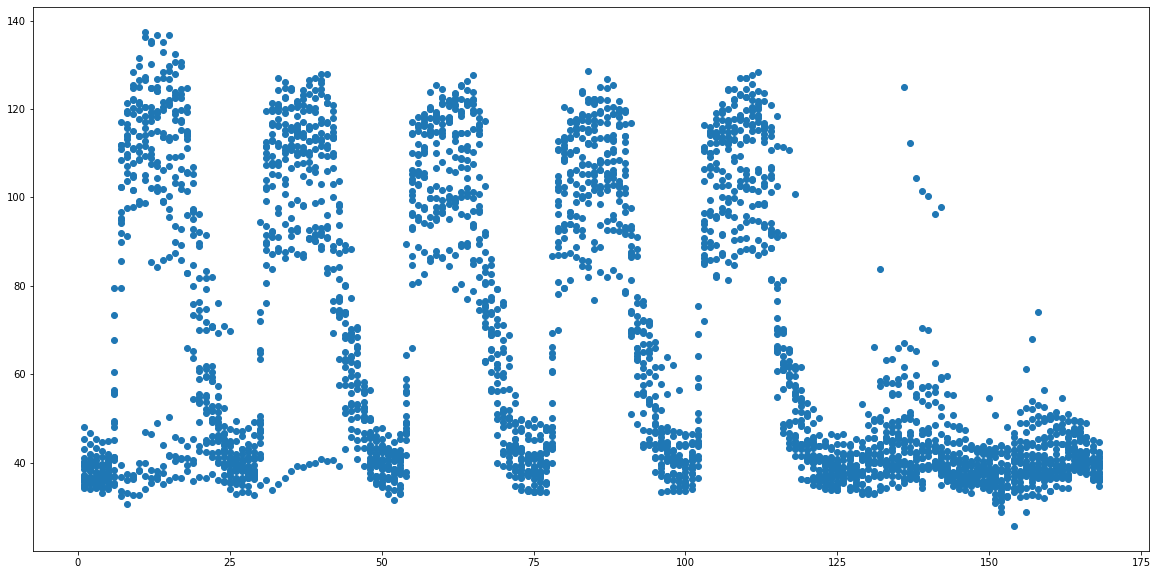

In [16]:
plt.scatter(df['hour_of_the_week'],df['Mean_Load'])

No handles with labels found to put in legend.


The average Silhouette Score is : 0.5203225465941544


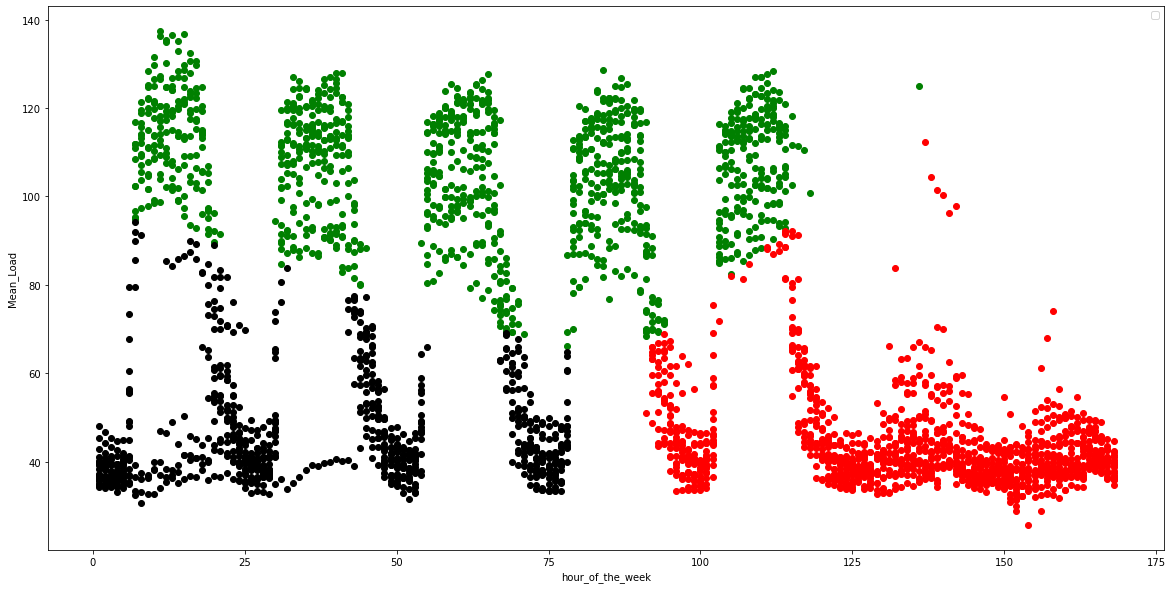

In [17]:
km = KMeans(n_clusters=3)
km

y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict

# df[["hour_of_the_week","Mean_Load"]].to_numpy()

Initial_cluster = y_predict
df['cluster1'] = y_predict
# Calculate Silhouette Score
silhouette_avg = silhouette_score(df[['hour_of_the_week', 'Mean_Load']], y_predict)
print("The average Silhouette Score is :", silhouette_avg)

df1 = df[df.cluster1==0]
df2 = df[df.cluster1==1]
df3 = df[df.cluster1==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

###### Scaling Techniques implementation

MinMax, Standardized, and Normalized scaling are three commonly used data scaling techniques in machine learning.
<br><br>
**MinMax scaling**: This scaling method scales the data to a fixed range, typically [0,1]. It works by subtracting the minimum value of the feature and dividing it by the range of the feature. The formula for MinMax scaling is:

x_scaled = (x - x_min) / (x_max - x_min)

where x is the original value of the feature, x_min and x_max are the minimum and maximum values of the feature, and x_scaled is the scaled value of the feature.
<br><br>
**Standardized scaling**: This scaling method scales the data so that it has a mean of 0 and a standard deviation of 1. It works by subtracting the mean of the feature and dividing it by the standard deviation of the feature. The formula for Standardized scaling is:

x_scaled = (x - mean(x)) / std(x)

where x is the original value of the feature, mean(x) is the mean of the feature, std(x) is the standard deviation of the feature, and x_scaled is the scaled value of the feature.
<br><br>
**Normalized scaling**: This scaling method scales the data so that the magnitude of each data point is 1. It works by dividing each value of the feature by the Euclidean norm of the feature. The formula for Normalized scaling is:

x_scaled = x / sqrt(sum(x^2))

where x is the original value of the feature, sum(x^2) is the sum of the squares of the feature, sqrt is the square root function, and x_scaled is the scaled value of the feature.

### MinMax Scalarizing

The average Silhouette Score is : 0.5656679870154226


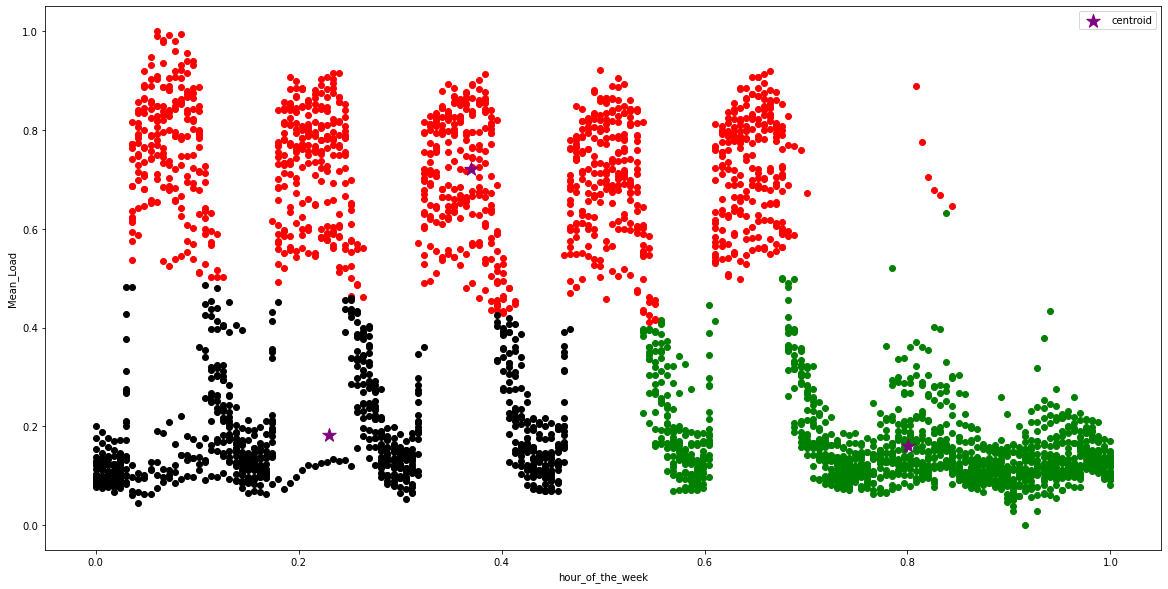

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


df = fillna_value()
scaler = MinMaxScaler()

# Fit and transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns
df


km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict
silhouette_avg = silhouette_score(df[['hour_of_the_week', 'Mean_Load']], y_predict)
print("The average Silhouette Score is :", silhouette_avg)

km.cluster_centers_

MinMax_cluster3 = y_predict
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size, label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

##### Using the MinMax technique we would like to know the possible clusters that we could have so therefore we do an elbow calculation on the data

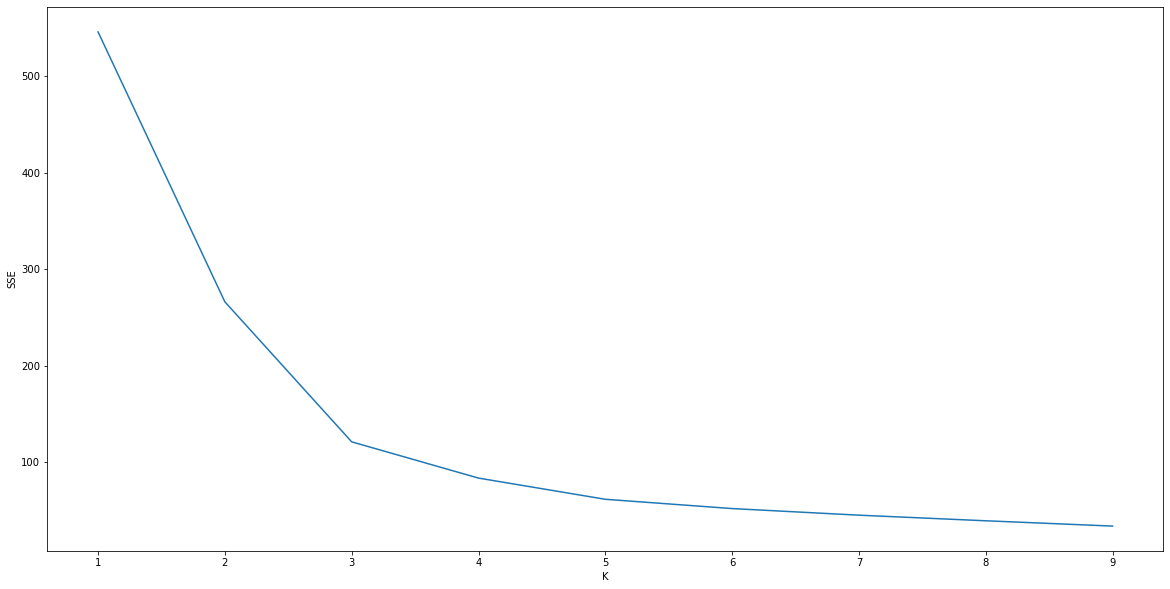

In [19]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

sse

plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

### Normalizer

The average Silhouette Score is : 0.6526658589048588


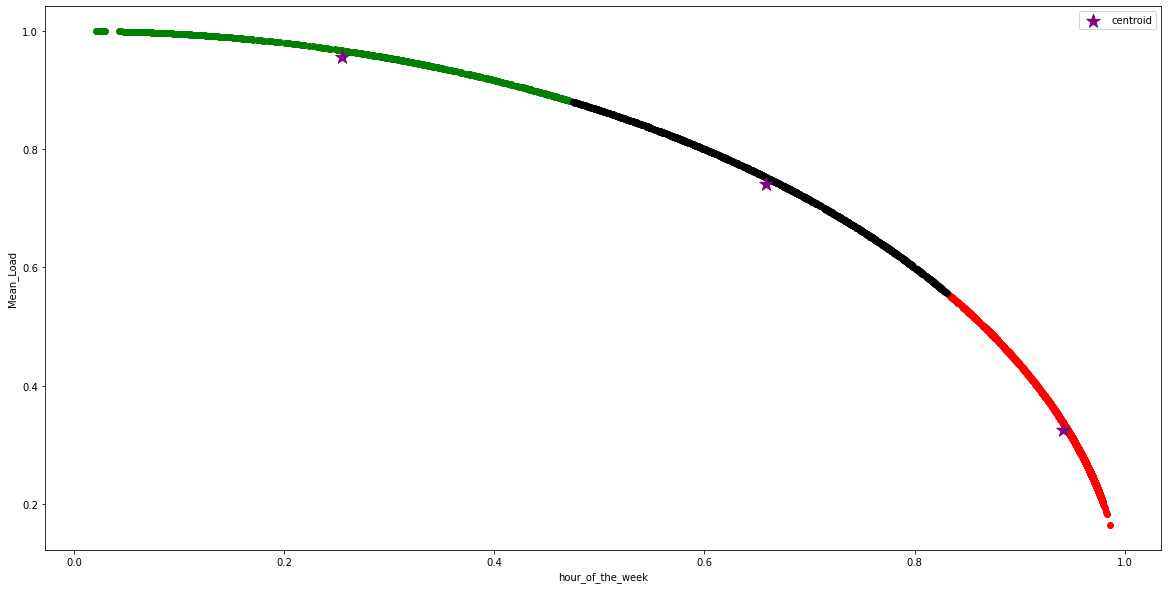

In [20]:
import pandas as pd
from sklearn.preprocessing import Normalizer

df = fillna_value()
scaler = Normalizer()

# Transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns



km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict
silhouette_avg = silhouette_score(df[['hour_of_the_week', 'Mean_Load']], y_predict)
print("The average Silhouette Score is :", silhouette_avg)

km.cluster_centers_

Normz_cluster3 = y_predict
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size,label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

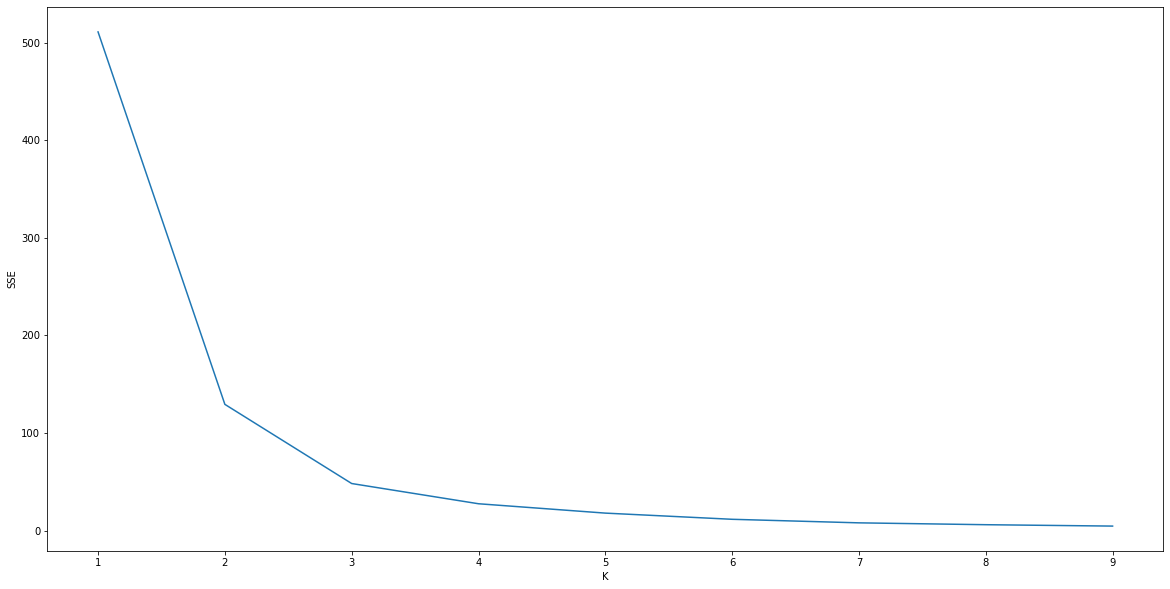

In [21]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

### Standardized Scalar

      hour_of_the_week  Mean_Load
0             0.993930  -0.919953
1             1.014358  -0.749238
2             1.034787  -0.830611
3             1.055215  -0.751152
4             1.075644  -0.635264
...                ...        ...
3271         -0.824215   0.405782
3272         -0.803786   0.319234
3273         -0.783358  -0.022613
3274         -0.762929  -0.303407
3275         -0.742501  -0.333725

[3276 rows x 2 columns]
The average Silhouette Score is : 0.5679467804291103


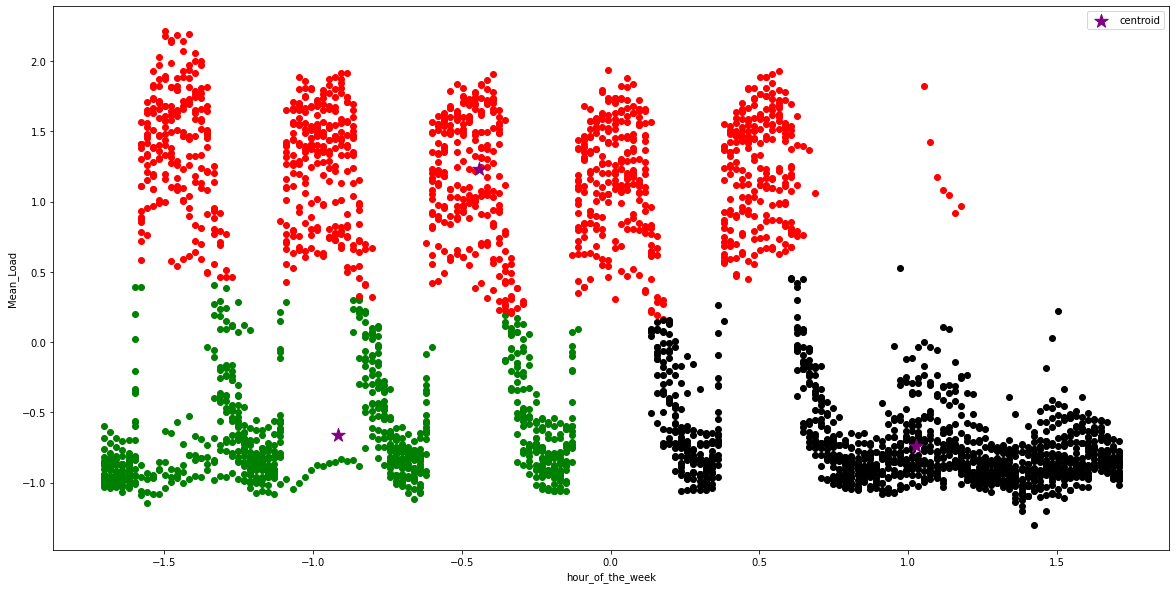

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = fillna_value()
df.fillna(value=0, inplace = True)
scaler = StandardScaler()

# Fit and transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns
print(df)


km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict
silhouette_avg = silhouette_score(df[['hour_of_the_week', 'Mean_Load']], y_predict)
print("The average Silhouette Score is :", silhouette_avg)

km.cluster_centers_

std_cluster3 = y_predict
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size,label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

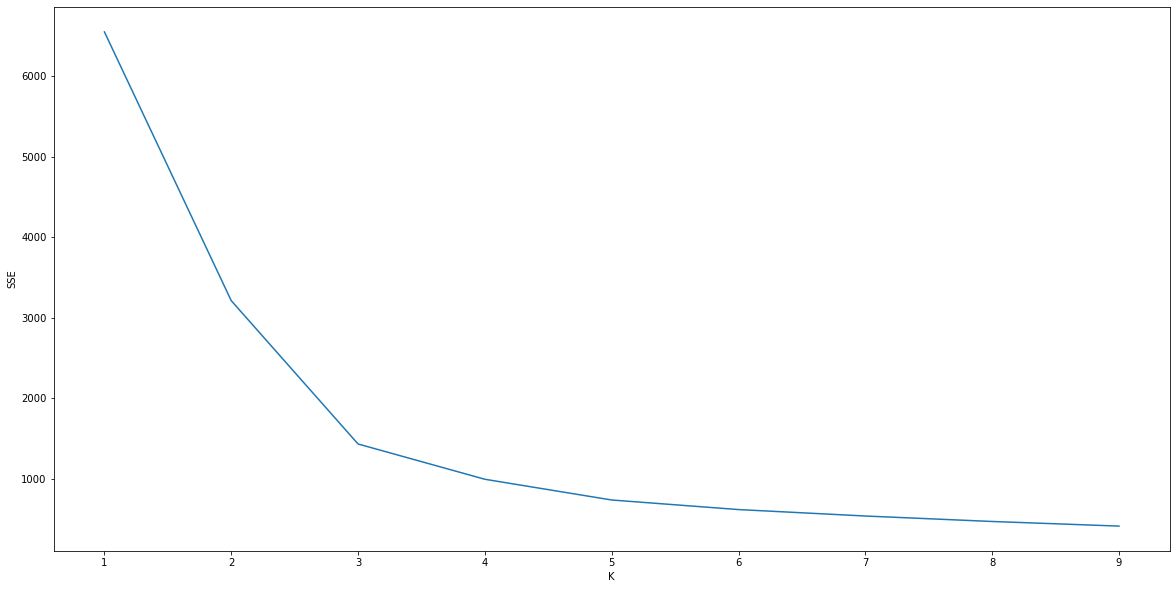

In [23]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

###### we try to append the various clustering to the initial raw data so as to be able to find out the nature of the clusters in its raw form

In [24]:
df = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\main2.parquet")
df['Initial_cluster3'] = Initial_cluster
df['Normz_cluster3']= Normz_cluster3
df['std_cluster3']= std_cluster3
df['MinMax_cluster3']= MinMax_cluster3
df

,Time,week_date,Max_Load,Min_Load,Mean_Load,hour_of_the_week,WeekDay,Initial_cluster3,Normz_cluster3,std_cluster3,MinMax_cluster3
0,2022-09-17 12:00:00,2022-09-11 (week 37),46.666,29.376,37.835000,133,Saturday,1,1,2,0
1,2022-09-17 13:00:00,2022-09-11 (week 37),51.045,31.066,43.259552,134,Saturday,1,1,2,0
2,2022-09-17 14:00:00,2022-09-11 (week 37),45.432,35.635,40.673883,135,Saturday,1,1,2,0
3,2022-09-17 15:00:00,2022-09-11 (week 37),47.489,36.948,43.198733,136,Saturday,1,1,2,0
4,2022-09-17 16:00:00,2022-09-11 (week 37),59.146,36.043,46.881117,137,Saturday,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
3271,2023-01-31 19:00:00,2023-01-29 (week 5),87.146,72.626,79.960733,44,Tuesday,0,2,1,1
3272,2023-01-31 20:00:00,2023-01-29 (week 5),82.882,70.813,77.210667,45,Tuesday,2,2,1,1
3273,2023-01-31 21:00:00,2023-01-29 (week 5),76.380,57.502,66.348317,46,Tuesday,2,2,0,2
3274,2023-01-31 22:00:00,2023-01-29 (week 5),62.340,52.269,57.426000,47,Tuesday,2,2,0,2


In [25]:
df.to_parquet('cluster3.parquet')

# Next step

###### Check Silhoutte Scores

tends to zero (0 - 1)


Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

###### Findings

Ways to cluster the time series data

- Agglomerative clustering: This type of clustering includes the distance matrix to cluster the time series data set.  
- Time series K-Means: It is a very basic way that can include euclidean, dynamic time warping, or soft dynamic time warping. 
- Kernel K-Means: This method is similar to the time series k-means but in it for clustering data, we rely on the kernel trick that mainly introduces a positive semidefinite.
- K-means DBA clustering: This type of clustering includes averaging strategy DTW barycenter averaging for clustering the time series data. 
- K-Medoid clustering: This type of clustering includes a distance matrix to perform k-medoid clustering. 


[Other time series classification model](https://github.com/Tobi-DataDetective/Energy_Load_Profile_Classification/blob/main/paper1.pdf)
 <br>
[Kaggle](https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering)

ML Models For Time-Series Forecasting
 

* ARIMA Model: As mentioned in the above section, it is a combination of three different models itself, AR, MA and I, where
   - “AR” reflects the evolving variable of interest is regressed on its own prior values,
   - “MA” infers that the regression error is the linear combination of error terms values happened at various stages of time priorly, and
   - “I” shows the data values are replaced by the difference between their values and the previous values.

* Combinedly “ARIMA” tries to fit the data into the model, and also ARIMA depends on the accuracy over a broad width of time series.

 

* ARCH/GARCH Model: Being the extended model of its common version GARCH, Autoregressive Conditional Heteroscedasticity (ARCH) is the most volatile model for time series forecasting, and are well trained for catching dynamic variations of volatility from time series.
 

* Vector Autoregressive Model or VAR model:  It gives the independencies between various time-series data which as a generalization of the Univariate Autoregression Model.
 

* LSTM: Long-short term memory(LSTM)is a deep learning model, it is a kind of Recurrent Neural Network(RNN) to read the sequence dependencies.
 

It enables us to handle long structures during training the dataset and creates predictions according to previous data.  

 

The blog ends here, we have discussed so far about time series analysis and its model, its role in financial analysis including various examples, and the impact of machine learning on time series along with applications.

 



2022-02-11 02:10:00  ====>  132  ====> Mean Load value / Load Class 

In [26]:
df

,Time,week_date,Max_Load,Min_Load,Mean_Load,hour_of_the_week,WeekDay,Initial_cluster3,Normz_cluster3,std_cluster3,MinMax_cluster3
0,2022-09-17 12:00:00,2022-09-11 (week 37),46.666,29.376,37.835000,133,Saturday,1,1,2,0
1,2022-09-17 13:00:00,2022-09-11 (week 37),51.045,31.066,43.259552,134,Saturday,1,1,2,0
2,2022-09-17 14:00:00,2022-09-11 (week 37),45.432,35.635,40.673883,135,Saturday,1,1,2,0
3,2022-09-17 15:00:00,2022-09-11 (week 37),47.489,36.948,43.198733,136,Saturday,1,1,2,0
4,2022-09-17 16:00:00,2022-09-11 (week 37),59.146,36.043,46.881117,137,Saturday,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
3271,2023-01-31 19:00:00,2023-01-29 (week 5),87.146,72.626,79.960733,44,Tuesday,0,2,1,1
3272,2023-01-31 20:00:00,2023-01-29 (week 5),82.882,70.813,77.210667,45,Tuesday,2,2,1,1
3273,2023-01-31 21:00:00,2023-01-29 (week 5),76.380,57.502,66.348317,46,Tuesday,2,2,0,2
3274,2023-01-31 22:00:00,2023-01-29 (week 5),62.340,52.269,57.426000,47,Tuesday,2,2,0,2


# UPDATE

16 other models were developed following the same above logic but based on the same KMeans algorithm. This is so that we exsuxt all the possible outcome of the algorthm and we are sure of the possible level of accuracy we could get from using this algorithm. 
On this algorithm just as said before a silhoutte test would be carried out on the various algorithm to check for the yet, best possible KMeans model developed.

other various model development files can be found here,
<br>
[Script](https://drive.google.com/drive/u/1/folders/1ajFABIrfqjr13taWQ_oZibbhFdlCkFYx) : this is the file for models built on 3 clusters<br>
[Script2](https://drive.google.com/drive/u/1/folders/1ajFABIrfqjr13taWQ_oZibbhFdlCkFYx) :  this is the file for models built on 2 clusters<br>
[Script4](https://drive.google.com/drive/u/1/folders/1ajFABIrfqjr13taWQ_oZibbhFdlCkFYx): this is the file for models built on 4 clusters<br>
[Script5](https://drive.google.com/drive/u/1/folders/1ajFABIrfqjr13taWQ_oZibbhFdlCkFYx): this is the file for models built on 5 clusters<br>

In [27]:
df2 = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\cluster2.parquet")
df3 = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\cluster3.parquet")
df4 = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\cluster4.parquet")
df5 = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\cluster5.parquet")


df = pd.concat([df2,df3, df4,df5], axis=1)
df = df.loc[:,~df.columns.duplicated()].copy()
df

,Time,week_date,Max_Load,Min_Load,Mean_Load,hour_of_the_week,WeekDay,Initial_cluster2,Normz_cluster2,std_cluster2,...,std_cluster3,MinMax_cluster3,Initial_cluster4,Normz_cluster4,std_cluster4,MinMax_cluster4,Initial_cluster5,Normz_cluster5,std_cluster5,MinMax_cluster5
0,2022-09-17 12:00:00,2022-09-11 (week 37),46.666,29.376,37.835000,133,Saturday,0,0,1,...,2,0,0,1,0,2,4,0,3,1
1,2022-09-17 13:00:00,2022-09-11 (week 37),51.045,31.066,43.259552,134,Saturday,0,0,1,...,2,0,0,1,0,2,4,0,3,1
2,2022-09-17 14:00:00,2022-09-11 (week 37),45.432,35.635,40.673883,135,Saturday,0,0,1,...,2,0,0,1,0,2,4,0,3,1
3,2022-09-17 15:00:00,2022-09-11 (week 37),47.489,36.948,43.198733,136,Saturday,0,0,1,...,2,0,0,1,0,2,4,0,3,1
4,2022-09-17 16:00:00,2022-09-11 (week 37),59.146,36.043,46.881117,137,Saturday,0,0,1,...,2,0,0,1,0,2,4,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,2023-01-31 19:00:00,2023-01-29 (week 5),87.146,72.626,79.960733,44,Tuesday,1,1,0,...,1,1,3,0,1,0,1,1,0,4
3272,2023-01-31 20:00:00,2023-01-29 (week 5),82.882,70.813,77.210667,45,Tuesday,1,1,0,...,1,1,2,0,2,1,1,1,0,4
3273,2023-01-31 21:00:00,2023-01-29 (week 5),76.380,57.502,66.348317,46,Tuesday,1,1,0,...,0,2,2,0,2,1,2,4,2,0
3274,2023-01-31 22:00:00,2023-01-29 (week 5),62.340,52.269,57.426000,47,Tuesday,1,1,0,...,0,2,2,0,2,1,2,4,2,0


### Below are the various model clustering outcomes derived (being set as columns in the above spread) in the various script listed above 


- **Initial_cluster2:** model build on 2 clusters but using the raw time and load column figures without any form of scaling
<br><br>
- **Normz_cluster2:** model built on 2 clusters but using Normalized scaling technique
<br><br>
- **std_cluster2:** model built on 2 clusters but using standardized scaling technique
<br><br>
- **MinMax_cluster2:** model built on 2 clusters but using MinMax scaling technique
<br><br>
- **Initial_cluster3:** model build on 3 clusters but using the raw time and load column figures without any form of scaling
<br><br>
- **Normz_cluster3:** model built on 3 clusters but using Normalized scaling technique
<br><br>
- **std_cluster3:** model built on 3 clusters but using standardized scaling technique
<br><br>
- **MinMax_cluster3:** model built on 3 clusters but using MinMax scaling technique
<br><br>
- **Initial_cluster4:** model build on 4 clusters but using the raw time and load column figures without any form of scaling
<br><br>
- **Normz_cluster4:** model built on 4 clusters but using Normalized scaling technique
<br><br>
- **std_cluster4:** model built on 4 clusters but using standardized scaling technique
<br><br>
- **MinMax_cluster4:** model built on 4 clusters but using MinMax scaling technique
<br><br>
- **Initial_cluster5:** model build on 5 clusters but using the raw time and load column figures without any form of scaling
<br><br>
- **Normz_cluster5:** model built on 5 clusters but using Normalized scaling technique
<br><br>
- **std_cluster5:** model built on 5 clusters but using standardized scaling technique
<br><br>
- **MinMax_cluster5:** model built on 5 clusters but using MinMax scaling technique


In [28]:

def fillna_value():
    z = df[['hour_of_the_week','Mean_Load']]
    Mean_Load = df.Mean_Load.mean()
    Max_Load = df.Max_Load.mean()
    Min_Load = df.Min_Load.mean()
    
    df['Mean_Load'].fillna(value=Mean_Load, inplace=True)
    df['Max_Load'].fillna(value=Max_Load, inplace=True)
    df['Min_Load'].fillna(value=Min_Load, inplace=True)
    
    return df

df = fillna_value()

for i in df.columns[7:]:
    array = df[i].to_numpy()
    silhouette_avg = silhouette_score(df[['hour_of_the_week', 'Mean_Load']], array)
    print(i ," : ", silhouette_avg )


Initial_cluster2  :  0.48996430615981185
Normz_cluster2  :  0.4489217990737207
std_cluster2  :  0.48010550906832383
MinMax_cluster2  :  0.4828396352902301
Initial_cluster3  :  0.5203225465941544
Normz_cluster3  :  0.3709699185320701
std_cluster3  :  0.5194781762230476
MinMax_cluster3  :  0.5197155181956612
Initial_cluster4  :  0.532579885021077
Normz_cluster4  :  0.3136184969669059
std_cluster4  :  0.5317168048784634
MinMax_cluster4  :  0.5323103819827553
Initial_cluster5  :  0.5334219533826399
Normz_cluster5  :  0.29733169413821836
std_cluster5  :  0.5275297022898429
MinMax_cluster5  :  0.529042511675535


Below are the various silhoutte scores for each model
<br>

Initial_cluster2  :  0.48996430615981185
<br><br>
Normz_cluster2  :  0.4489217990737207
<br><br>
std_cluster2  :  0.48010550906832383
<br><br>
MinMax_cluster2  :  0.4828396352902301
<br><br>
Initial_cluster3  :  0.5203225465941544
<br><br>
Normz_cluster3  :  0.3709699185320701
<br><br>
std_cluster3  :  0.5194781762230476
<br><br>
MinMax_cluster3  :  0.5197155181956612
<br><br>
Initial_cluster4  :  0.532579885021077
<br><br>
Normz_cluster4  :  0.3136184969669059
<br><br>
std_cluster4  :  0.5317168048784634
<br><br>
MinMax_cluster4  :  0.5323103819827553
<br><br>
Initial_cluster5  :  0.5334219533826399
<br><br>
Normz_cluster5  :  0.29733169413821836
<br><br>
std_cluster5  :  0.5275297022898429
<br><br>
MinMax_cluster5  :  0.529042511675535
<br><br>

Based on prinicple, elbow, and silhoutte test all other analysis would be based off of Initial_cluster5 model i.e 5 classes will generate optimum prediction performance

###### Next Step is Property identification of this cluster model
This is to help understand why this classification was made, and the basis of which it was made
- Visual Exploration
- Statistical analysis: mean, median, max, min, standard deviation, variation, 
- Inferiential analysis: ANOVA, hypothesis testing